In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from model.informer import informer

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from torch_geometric.loader import DataLoader
from Data_provider import *
from exp import *

In [4]:

#参数表
parameter={"seq_len":96,"pred_len":24,"d_model":256,"n_heads":4,"e_layers":2,"d_layers":2,"c_out":1,"enc_in":1}#n_heads=1

In [5]:
df=pd.read_csv("./electricity.csv")
data=np.array(df["y"]).reshape(df["y"].shape[0],-1)

In [6]:
window_size=96
pred_size=24
train_data, test_data, scaler = normalize_and_split(data)

# 滑动窗口数据准备
train_windows = sliding_window(train_data, window_size,pred_size)
test_windows = sliding_window(test_data, window_size,pred_size)

In [7]:
train_dataset = create_dataset(train_windows)#drop 掉最后一个
test_dataset = create_dataset(test_windows)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 创建模型
model = informer(parameter)

# 优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [10]:
model

informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=256, out_features=256, bias=True)
          (key_projection): Linear(in_features=256, out_features=256, bias=True)
          (value_projection): Linear(in_features=256, out_features=256, bias=True)
          (out_projection): Linear(in_features=256, out_features=256, bias=True)
        )
        (conv1): Conv1d(256, 1024, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(1024, 256, kernel_size=(1,), stride=(1,))


In [11]:
#训练函数--informer
def train(model, train_loader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch[0])
            #rint(batch.y.size())
            y = batch[1]
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

In [12]:
#测试函数--informer
def pred(model,test_loader):
    out_list=[]
    true_list=[]
    for batch in test_loader:
        out=model(batch[0])
        #print(out.shape)
        true=batch[1]
        out_list.append(out.detach().numpy())
        true_list.append(true.detach().numpy())
    
    return np.vstack(out_list),np.vstack(true_list)

In [13]:
train(model, train_loader, optimizer, criterion, epochs=10)

Epoch: 1, Loss: 0.013445630669593811
Epoch: 2, Loss: 0.008112311363220215
Epoch: 3, Loss: 0.0054466272704303265
Epoch: 4, Loss: 0.005221640691161156
Epoch: 5, Loss: 0.005545647349208593
Epoch: 6, Loss: 0.004487326834350824
Epoch: 7, Loss: 0.004887348040938377
Epoch: 8, Loss: 0.004349543713033199
Epoch: 9, Loss: 0.004232980310916901
Epoch: 10, Loss: 0.004294001962989569


In [14]:
y_hat,y_true=pred(model,test_loader)

In [15]:
mse,mae=Metrics(y_hat.reshape(-1,1),y_true.reshape(-1,1))

0.0067502335
0.06866484


In [16]:
pred=inverse_transform(y_hat)
true=inverse_transform(y_true)

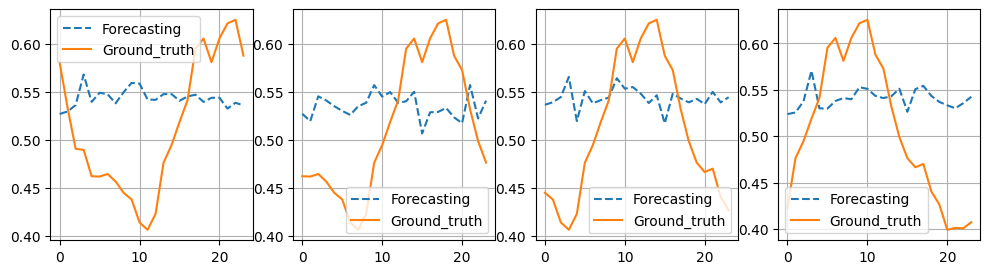

In [17]:
plt.figure(figsize=(12,3))
aa=111
window_size=24

plt.subplot(141)
plt.plot(pred[0],"--")
plt.plot(true[0])
plt.legend(["Forecasting","Ground_truth"])
plt.grid(1)

plt.subplot(142)
plt.plot(pred[4],"--")
plt.plot(true[4])
plt.legend(["Forecasting","Ground_truth"])
plt.grid(1)

plt.subplot(143)
plt.plot(pred[8],"--")
plt.plot(true[8])
plt.legend(["Forecasting","Ground_truth"])
plt.grid(1)

plt.subplot(144)
plt.plot(pred[12],"--")
plt.plot(true[12])
plt.legend(["Forecasting","Ground_truth"])
plt.grid(1)